In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Aug  4 08:24:19 2024

@author: jadi
"""

import numpy as np
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from DynSysSim import simulateCoopDyad
import warnings


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

AUC Score: 0.6660
AUC Score: 0.6719
AUC Score: 0.5658
AUC Score: 0.6370
AUC Score: 0.6268
AUC Score: 0.6243


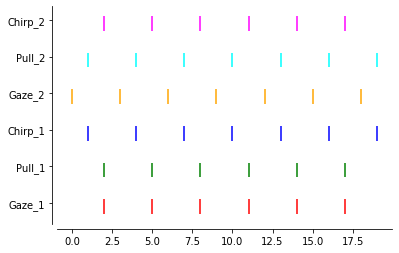

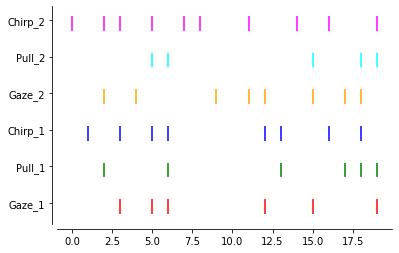

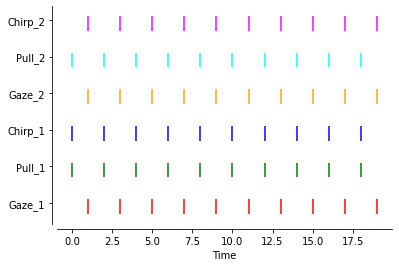

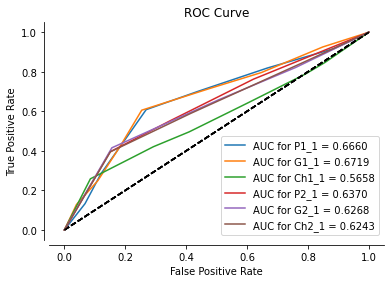

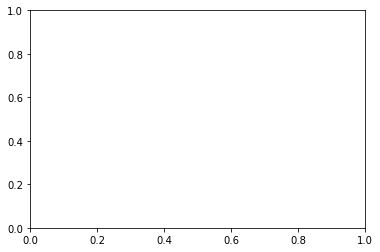

In [2]:

# Suppress all warnings
# warnings.simplefilter('ignore')

#Simulate the dynamical system of cooperation dyad
simulateCoopDyad(0) #Show the ideal dynamics for demo
simulateCoopDyad(0.2) #show noisy dynamics and fit model with this data


# Read simulated data for two time slices
df = pd.read_csv('simulated_dyad.csv')

data = pd.DataFrame({
    'G1_0': df['G1_0'].values,
    'G2_0': df['G2_0'].values,
    'P1_0': df['P1_0'].values,
    'P2_0': df['P2_0'].values,
    'Ch1_0': df['Ch1_0'].values,
    'Ch2_0': df['Ch2_0'].values,
    'G1_1': df['G1_1'].values,
    'G2_1': df['G2_1'].values,
    'P1_1': df['P1_1'].values,
    'P2_1': df['P2_1'].values,
    'Ch1_1': df['Ch1_1'].values,
    'Ch2_1': df['Ch2_1'].values
})

# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2)

# Define the Dynamic Bayesian Network
# A = np.array([[-T,0,0,1,0,1], #G1
#               [0,-T,1,0,0,0], #G2
#               [1,0,-T,0,1,0], #P1
#               [0,1,0,-T,0,0], #P2
#               [0,0,0,-4,-T,0], #Ch_1
#               [0,0,0,1,0,-T]]) #Ch_2

bn = BayesianNetwork([('P2_0', 'G1_1'), ('Ch2_0', 'G1_1'), ('G1_0', 'G1_1'), #G1
                      ('P1_0', 'G2_1'), ('G2_0', 'G2_1'),                    #G2
                      ('G1_0', 'P1_1'), ('Ch1_0', 'P1_1'), ('P1_0', 'P1_1'), #P1
                      ('G2_0', 'P2_1'), ('P2_0', 'P2_1'),                    #P2
                      ('G2_0', 'Ch1_1'), ('P2_0', 'Ch1_1'), ('Ch1_0', 'Ch1_1'),                 #Ch1
                      ('P2_0', 'Ch2_1'), ('Ch2_0', 'Ch2_1'),])               #Ch2

effect_slice = ['P1_1', 'G1_1', 'Ch1_1', 'P2_1', 'G2_1', 'Ch2_1']

# Perform parameter learning for each time slice
bn.fit(train_data, estimator=MaximumLikelihoodEstimator)

# Perform inference
infer = VariableElimination(bn)

# Predict behavior dynamics
time_steps = 100
# initial evidence
b0 = np.random.randint(0,2,6)
evidence = {'P1_0': b0[0], 'G1_0': b0[1], 'Ch1_0':b0[2], 'P2_0':b0[3], 'G2_0':b0[4], 'Ch2_0':b0[5]}
# predicted behavior + Pbehavior init
behavior = np.zeros([6,time_steps+1], dtype=int)  #most predicted outcome
Pbehavior = np.zeros([6,time_steps+1]) #probability of most predicted outcome
behavior[0,0] = evidence['G1_0']
behavior[1,0] = evidence['P1_0']
behavior[2,0] = evidence['Ch1_0']
behavior[3,0] = evidence['G2_0']
behavior[4,0] = evidence['P2_0']
behavior[5,0] = evidence['Ch2_0']

for t in range(time_steps):
    infer = VariableElimination(bn)
    predBehavior = infer.map_query(variables=effect_slice, evidence=evidence) 

    # Extract the probability of the MAP outcome
    behavior[0,t+1] = int(predBehavior['G1_1'])
    behavior[1,t+1] = int(predBehavior['P1_1'])
    behavior[2,t+1] = int(predBehavior['Ch1_1'])
    behavior[3,t+1] = int(predBehavior['G2_1'])
    behavior[4,t+1] = int(predBehavior['P2_1'])
    behavior[5,t+1] = int(predBehavior['Ch2_1'])
  
    evidence = {'P1_0': predBehavior['P1_1'], 'G1_0': predBehavior['G1_1'], 'Ch1_0': predBehavior['Ch1_1'], 'P2_0':predBehavior['P2_1'], 'G2_0':predBehavior['G2_1'], 'Ch2_0': predBehavior['Ch2_1']}

#Plot simulated data
behVarName = ['Gaze_1', 'Pull_1', 'Chirp_1', 'Gaze_2', 'Pull_2', 'Chirp_2']
behVarClr = ['red', 'green', 'blue', 'orange', 'cyan', 'magenta']
fig,ax = plt.subplots(1)
for b in range(6):
    beh_times = np.where(behavior[b,80:100] == 1)[0]
    ax.vlines(beh_times, b+0.7, b+1.1, colors=behVarClr[b], label=behVarName[b])
    ax.set_xlabel('Time')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Optionally, you can also move the left and bottom spines
    # to make the plot look like a traditional "box off" plot in MATLAB
    ax.spines['left'].set_position(('outward', 5))
    ax.spines['bottom'].set_position(('outward', 5))

ax.set_yticks(np.arange(0,6,1) + 1)
ax.set_yticklabels(behVarName)

##############################################
# Calculate AUC on test data
##############################################
# Compute the prediction prob./score
fig,ax = plt.subplots(1)
fig2,ax2 = plt.subplots(1)
for var in effect_slice:
    Pbehavior = [] # Initialize log-likelihood
    bhvevents = []
    for index, row in test_data.iterrows():
        evidence = {'P1_0': row['P1_0'], 'G1_0': row['G1_0'], 'Ch1_0':row['Ch1_0'], 'P2_0':row['P2_0'], 'G2_0':row['G2_0'], 'Ch2_0':row['Ch2_0']}
        
        # Query the probability distribution for Pulls given evidence
        aucPpredBehavior = infer.query(variables=[var], evidence=evidence) 
        # predBehavior = infer.map_query(variables=[var], evidence=evidence)
    
        # Extract the probability of outcome = 1
        prob = aucPpredBehavior.values[1]
        Pbehavior = np.append(Pbehavior, prob)
        # bhvevents = np.append(bhvevents, predBehavior[var])
            
    # Calculate the AUC score
    trueBeh = test_data[var].values
    auc = roc_auc_score(trueBeh, Pbehavior)
    print(f"AUC Score: {auc:.4f}")
    
    # Optionally, plot the ROC curve
    fpr, tpr, _ = roc_curve(trueBeh, Pbehavior)

    ax.plot(fpr, tpr, label=f'AUC for {var:s} = {auc:.4f}')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc='lower right')
    
    if 0:
        # Calculate the AUC score - for the binary bhv events
        trueBeh = test_data[var].values
        auc = roc_auc_score(trueBeh, bhvevents)
        print(f"AUC Score: {auc:.4f}")

        # Optionally, plot the ROC curve
        fpr, tpr, _ = roc_curve(trueBeh, bhvevents)

        ax2.plot(fpr, tpr, label=f'AUC for {var:s} = {auc:.4f}')
        ax2.plot([0, 1], [0, 1], 'k--')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('ROC Curve - on behavioral events')
        ax2.legend(loc='lower right')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

if 0:
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

# Optionally, you can also move the left and bottom spines
# to make the plot look like a traditional "box off" plot in MATLAB
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
plt.show()

In [5]:
train_data

,G1_0,G2_0,P1_0,P2_0,Ch1_0,Ch2_0,G1_1,G2_1,P1_1,P2_1,Ch1_1,Ch2_1
8289,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
5501,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4466,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
7449,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8011,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7322,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
6007,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
1630,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
5855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [6]:
test_data

,G1_0,G2_0,P1_0,P2_0,Ch1_0,Ch2_0,G1_1,G2_1,P1_1,P2_1,Ch1_1,Ch2_1
6662,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2533,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2111,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
7988,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2358,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1136,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2006,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
5771,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
7959,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
